In [1]:
%matplotlib qt5
import numpy as np
import matplotlib.pyplot as plt
from idanalysis import IDKickMap
from mathphys.functions import save_pickle, load_pickle
import utils
import pymodels, pyaccel

In [32]:
def get_gap_str(gap):
    gap_str = '{:04.1f}'.format(gap).replace('.', 'p')
    return gap_str

def get_phase_str(phase):
    phase_str = '{:+07.3f}'.format(phase).replace('.', 'p')
    phase_str = phase_str.replace('+', 'pos').replace('-', 'neg')
    return phase_str

In [33]:
def get_meas_data_path(phase, gap):
    fpath = utils.FOLDER_DATA
    fpath = fpath.replace('model', 'measurements')
    phase_str = get_phase_str(phase)
    fpath = fpath.replace(
        'data/', 'data/phases/phase_{}/'.format(phase_str))
    gap_str = get_gap_str(gap)
    fpath += 'gap_{}/'.format(gap_str)
    return fpath

In [34]:
def get_field_data_fname(phase, gap):
    fpath = get_meas_data_path(phase=phase, gap=gap)
    sulfix = 'field_data'
    phase_str = get_phase_str(phase)
    sulfix += '_phase{}'.format(phase_str)
    gap_str = get_gap_str(gap)
    sulfix += '_gap{}'.format(gap_str)
    return fpath + sulfix

In [35]:
def get_data_plot(phase=0, gap=0):
    data_plot = dict()
    if utils.var_param == 'gap':
        for gap_ in utils.gaps:
            fname = get_field_data_fname(phase, gap_)
            try:
                fdata = load_pickle(fname)
                data_plot[gap_] = fdata
            except FileNotFoundError:
                print('File does not exist.')
    if utils.var_param == 'phase':
        for phase_ in utils.phases:
            fname = get_field_data_fname(phase_, gap)
            try:
                fdata = load_pickle(fname)
                data_plot[phase_] = fdata
            except FileNotFoundError:
                print('File does not exist.')
    return data_plot

In [38]:
def plot_field_on_axis(data, sulfix=None):
    colors = ['C0', 'b', 'g', 'y', 'C1', 'r', 'k']
    field_component = utils.field_component
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
    output_dir = utils.FOLDER_DATA + 'general'
    filename = 'field-profile'
    var_parameters = list(data.keys())
    for i, parameter in enumerate(var_parameters):
        label = 'I = {} A'.format(parameter)
        bx = data[parameter]['onaxis_bx']
        by = data[parameter]['onaxis_by']
        bz = data[parameter]['onaxis_bz']
        rz = data[parameter]['onaxis_rz']
        axs[0].plot(rz, bx, label=label, color=colors[i])
        axs[0].set_ylabel('Bx [T]')
        axs[1].plot(rz, by, label=label, color=colors[i])
        axs[1].set_ylabel('By [T]')
        axs[2].plot(rz, bz, label=label, color=colors[i])
        axs[2].set_ylabel('Bz [T]')
        for j in np.arange(3):
            axs[j].set_xlabel('z [mm]')
            axs[j].legend(loc='lower left')
            axs[j].grid()
    # plt.savefig(filename, dpi=300)
    plt.show()

In [39]:
def plot_rk_traj(data, sulfix=None):
    colors = ['C0', 'b', 'g', 'y', 'C1', 'r', 'k']
    var_parameters = list(data.keys())
    output_dir = utils.FOLDER_DATA + 'general'
    for i, parameter in enumerate(var_parameters):
        s = data[parameter]['ontraj_s']
        rx = data[parameter]['ontraj_rx']
        ry = data[parameter]['ontraj_ry']
        px = 1e6*data[parameter]['ontraj_px']
        py = 1e6*data[parameter]['ontraj_py']
        label = 'I = {} A'.format(parameter)

        plt.figure(1)
        plt.plot(s, 1e3*rx, color=colors[i], label=label)
        plt.xlabel('path length [mm]')
        plt.ylabel('x [um]')

        plt.figure(2)
        plt.plot(s, 1e3*ry, color=colors[i], label=label)
        plt.xlabel('path length [mm]')
        plt.ylabel('y [um]')
        plt.legend()

        plt.figure(3)
        plt.plot(s, px, color=colors[i], label=label)
        plt.xlabel('path length [mm]')
        plt.ylabel('px [urad]')

        plt.figure(4)
        plt.plot(s, py, color=colors[i], label=label)
        plt.xlabel('path length [mm]')
        plt.ylabel('py [urad]')
    sulfix_ = ['traj-rx', 'traj-ry', 'traj-px', 'traj-py']
    for i in [1, 2, 3, 4]:
        plt.figure(i)
        plt.legend()
        plt.grid()
        plt.tight_layout()
        filename = sulfix_[i-1]
        # plt.savefig(filename, dpi=300)
    plt.show()

In [90]:
def read_data_roll_off(data, parameter):
    field_component = 'by'
    if 'rolloff_{}'.format(field_component) in data[parameter]:
        b = data[parameter]['rolloff_{}'.format(field_component)]
        if 'rolloff_rt' in data[parameter]:
            rt = data[parameter]['rolloff_rt']
        elif 'rolloff_rx' in data[parameter]:
            rt = data[parameter]['rolloff_rx']
        elif 'rolloff_ry' in data[parameter]:
            rt = data[parameter]['rolloff_ry']
        rtp_idx = np.argmin(np.abs(rt - 5))
        rt0_idx = np.argmin(np.abs(rt))
        roff = np.abs(b[rtp_idx]/b[rt0_idx]-1)
        b0 = b[rt0_idx]
        roll_off = 100*(b/b0 - 1)
        return rt, b, roll_off, roff

In [40]:
def plot_field_roll_off(data, sulfix=None):
    field_component = utils.field_component
    plt.figure(1)
    output_dir = utils.FOLDER_DATA + 'general'
    output_dir = output_dir.replace('model', 'measurements')
    filename = output_dir + '/field-rolloff'
    if sulfix is not None:
        filename += sulfix
    colors = ['C0', 'b', 'g', 'y', 'C1', 'r', 'k']
    var_parameters = list(data.keys())
    for i, parameter in enumerate(var_parameters):
        roff_data = read_data_roll_off(data, parameter)
        if roff_data is None:
            continue
        else:
            rt, b, roll_off, roff = roff_data
        label = utils.var_param +\
            " {} mm, roll-off = {:.2f} %".format(parameter, 100*roff)
        plt.plot(rt, roll_off, '.-', label=label, color=colors[i])
    if field_component == 'by':
        plt.xlabel('x [mm]')
    else:
        plt.xlabel('y [mm]')
    plt.ylabel('Field roll off [%]')
    plt.xlim(-utils.ROLL_OFF_RT, utils.ROLL_OFF_RT)
    plt.ylim(-101*roff, 20*roff)
    if field_component == 'by':
        plt.title('Field roll-off at x = {} mm'.format(utils.ROLL_OFF_RT))
    elif field_component == 'bx':
        plt.title('Field roll-off at y = {} mm'.format(utils.ROLL_OFF_RT))
    plt.legend()
    plt.grid()
    # plt.savefig(filename, dpi=300)
    plt.show()

In [41]:
def run_plot_data(phase=0, gap=0, sulfix=None):
    data_plot = get_data_plot(phase=phase, gap=gap)
    plot_field_on_axis(data=data_plot,
                       sulfix=sulfix)
    # plot_rk_traj(data=data_plot, sulfix=sulfix)
        

In [42]:
phase = utils.phases[0]
run_plot_data(phase=phase,
              gap=utils.gaps[0],
              sulfix=None)

In [67]:
def plot_rk_curr(data, sulfix=None):
    colors = ['C0', 'b', 'g', 'y', 'C1', 'r', 'k']
    var_parameters = list(data.keys())
    output_dir = utils.FOLDER_DATA + 'general'
    rx, ry = list(), list()
    px, py = list(), list()
    curr = list()
    for i, parameter in enumerate(var_parameters):
        rx_ = 1e3*data[parameter]['ontraj_rx'][-1]
        ry_ = 1e3*data[parameter]['ontraj_ry'][-1]
        px_ = 1e6*data[parameter]['ontraj_px'][-1]
        py_ = 1e6*data[parameter]['ontraj_py'][-1]
        rx0_ = parameter
        rx.append(rx_)
        ry.append(ry_)
        px.append(px_)
        py.append(py_)
        curr.append(curr_)

    plt.figure(1)
    plt.plot(curr, rx, '.-', color=colors[1])
    plt.xlabel('Current [A]')
    plt.ylabel('final rx [um]')

    plt.figure(2)
    plt.plot(curr, ry, '.-', color=colors[-2])
    plt.xlabel('Current [A]')
    plt.ylabel('yf [um]')

    plt.figure(3)
    plt.plot(curr, px, '.-', color=colors[1])
    plt.xlabel('Current [A]')
    plt.ylabel('pxf [urad]')

    plt.figure(4)
    plt.plot(curr, py, '.-', color=colors[-2])
    plt.xlabel('Current [A]')
    plt.ylabel('pyf [urad]')
    sulfix_ = ['traj-rx-final', 'traj-ry-final', 'traj-px-final', 'traj-py-final']
    for i in [1, 2, 3, 4]:
        plt.figure(i)
        # plt.legend()
        plt.grid()
        plt.tight_layout()
        filename = sulfix_[i-1]
        plt.savefig(filename, dpi=300)
    plt.show()

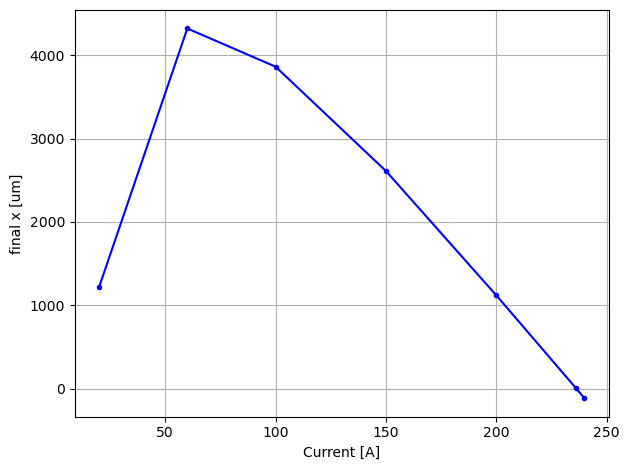

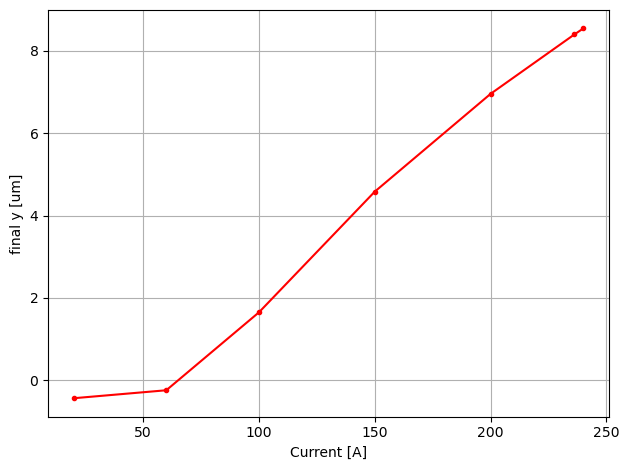

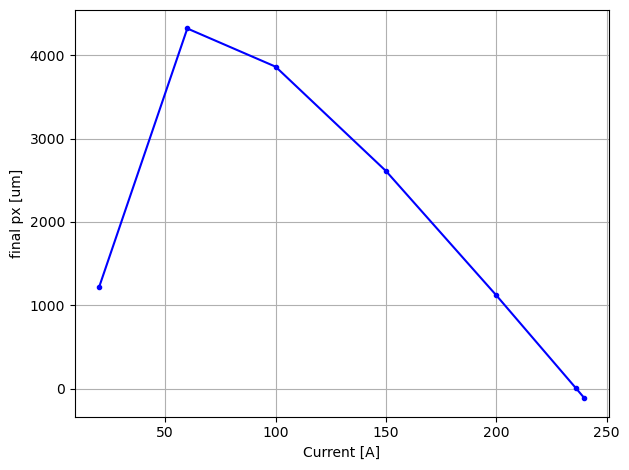

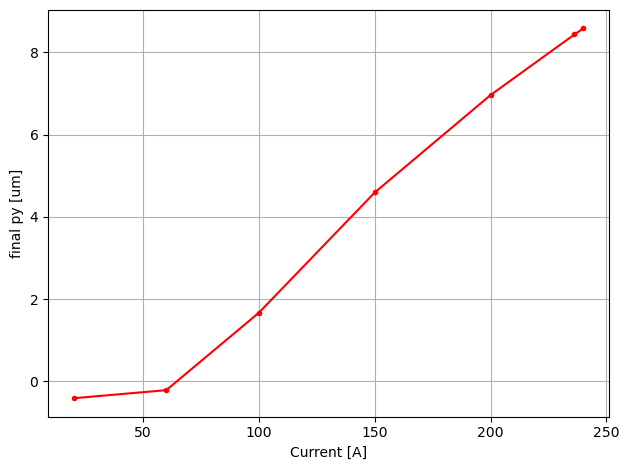

In [68]:
data_plot = get_data_plot(phase=0, gap=0)
plot_rk_curr(data_plot)

In [39]:
model = pymodels.si.create_accelerator()
famdata = pymodels.si.get_family_data(model)
idcs_q = famdata['QN']['index']
idcs_s = famdata['SN']['index']

In [56]:
kl = pyaccel.lattice.get_attribute(model, 'KL', idcs_q)
sl = pyaccel.lattice.get_attribute(model, 'SL', idcs_s)
k = pyaccel.lattice.get_attribute(model, 'K', idcs_q)
s = pyaccel.lattice.get_attribute(model, 'S', idcs_s)

In [72]:
np.abs(kl).min()

0.22673565770543608

In [78]:
np.abs(sl).min()*10

78.8544

In [77]:
sl.std()*10

223.46729148073052

In [81]:
np.abs(s).min()*10

525.696

In [2]:
from idanalysis.analysis import Tools

In [3]:
fmap, fname = Tools._get_fmap(phase=0, gap=240, config_idx=None)

ID007


In [56]:
plt.figure(1)
period = 50
by = fmap.by[fmap.ry_zero][fmap.rx_zero][:]
rx = fmap.rx
idxmax = np.argmin(
            by[int(len(by)/2-period):int(len(by)/2+period)])
idxmax += int(len(by)/2-period)

rzmax = fmap.rz[idxmax]
print('rz peak: {} mm'.format(rzmax))
print('b peak: {} T'.format(by[idxmax]))
print(idxmax)

idxmax = 990
plt.plot(rx, roff, color='C0')
    # plt.plot(rx, byx, label='roll off @ {} mm= {:.2} %'.format(
                # utils.ROLL_OFF_RT, roff))
# plt.legend()
plt.xlabel('rx [mm]')
plt.ylabel('B [T]')
plt.grid()
plt.show()

rz peak: 0.0 mm
b peak: -6.89481495750123 T
1000


In [4]:
fmaps_names = dict()
curr = 240
fmap, fname = Tools._get_fmap(phase=0, gap=curr, config_idx=None)
fmaps_names[curr] = fname

ID007


In [5]:
bx, by, bz = dict(), dict(), dict()
rz, rx, ry = dict(), dict(), dict()
px, py, pz = dict(), dict(), dict()
s = dict()
data = dict()
x0 = np.linspace(-1e-3, 1e-3, 5)
for rx0 in x0:
    # create IDKickMap and calc trajectory
    idkickmap = IDKickMap()
    fmap_fname = fmaps_names[curr]
    idkickmap.fmap_fname = fmap_fname
    idkickmap.beam_energy = utils.BEAM_ENERGY
    idkickmap.rk_s_step = utils.DEF_RK_S_STEP
    idkickmap.kmap_idlen = 1.2
    idkickmap.fmap_calc_trajectory(
            traj_init_rx=rx0, traj_init_ry=0,
            traj_init_px=0, traj_init_py=0)
    traj = idkickmap.traj
    bx[rx0], by[rx0], bz[rx0] =\
        traj.bx, traj.by, traj.bz
    rx[rx0], ry[rx0], rz[rx0] =\
        traj.rx, traj.ry, traj.rz
    px[rx0], py[rx0], pz[rx0] =\
        traj.px, traj.py, traj.pz
    s[rx0] = traj.s

data['ontraj_bx'] = bx
data['ontraj_by'] = by
data['ontraj_bz'] = bz

data['ontraj_rx'] = rx
data['ontraj_ry'] = ry
data['ontraj_rz'] = rz

data['ontraj_px'] = px
data['ontraj_py'] = py
data['ontraj_pz'] = pz

data['ontraj_s'] = s

Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.493862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.493862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.493862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.493862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.243862 > rz_max = 1000.000000 [mm]
Rz extrapolation rz = 1000.493862 > rz_max = 1000.000000 [mm]


In [7]:
save_pickle(data, 'traj_240_no_roff', overwrite=True)

In [8]:
by = data['ontraj_by']
s = data['ontraj_s']
px = data['ontraj_px']
rx = data['ontraj_rx']

In [10]:
for rx0 in x0:
    by_ = by[rx0]
    s_ = s[rx0]
    px_ = px[rx0]
    rx_ = rx[rx0]
    rxf = rx_[-1]
plt.plot(s_, 1e6*px_)